Test selecting road points and bounding bounding boxes of roads 

In [3]:
%matplotlib inline

import collections
import math
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import dill
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import cv2 as cv

import carla
import utility as util
import carlautil
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000

Trajectron helpers

In [4]:
def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

def scenes_to_df(scenes):
    dfs = []
    for scene in scenes:
        df = scene_to_df(scene)
        # df.loc[df['node_id'] == 'ego','node_id'] = agent_id
        df['node_id'] = scene.name + '/' + df['node_id']
        df[['position_x', 'position_y']] += np.array([scene.x_min, scene.y_min])
        dfs.append(df)
    return pd.concat(dfs)

Extract road polygons

In [5]:
def get_world_with(client, map_name):
    world = client.get_world()
    carla_map = world.get_map()
    if carla_map.name != map_name:
        world = client.load_world(map_name)
        carla_map = world.get_map()
    return world, carla_map

def get_client_and_world_with(map_name):
    client = carla.Client(CARLA_HOST, CARLA_PORT)
    client.set_timeout(10.0)
    world, carla_map = get_world_with(client, map_name)
    return client, world, carla_map

map_name = "Town03"
roadpath = f"../cache/map_data.{map_name}.pkl"
with open(roadpath, 'rb') as f:
    payload = dill.load(f, encoding='latin1')
road_polygons = payload['road_polygons']
white_lines   = payload['white_lines']
yellow_lines  = payload['yellow_lines']
junctions     = payload['junctions']
spawn_points  = payload['spawn_points']

Helper functions for map rendering and getting road bounding boxes.

In [6]:
def render_entire_map(ax):
    for poly in road_polygons:
        patch = patches.Polygon(poly[:, :2], fill=True, color='grey')
        ax.add_patch(patch)
    for line in yellow_lines:
        ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
    for line in white_lines:
        ax.plot(line.T[0], line.T[1], c='white', linewidth=2)


Plot all the junctions and entrance/exits to/from the junctions

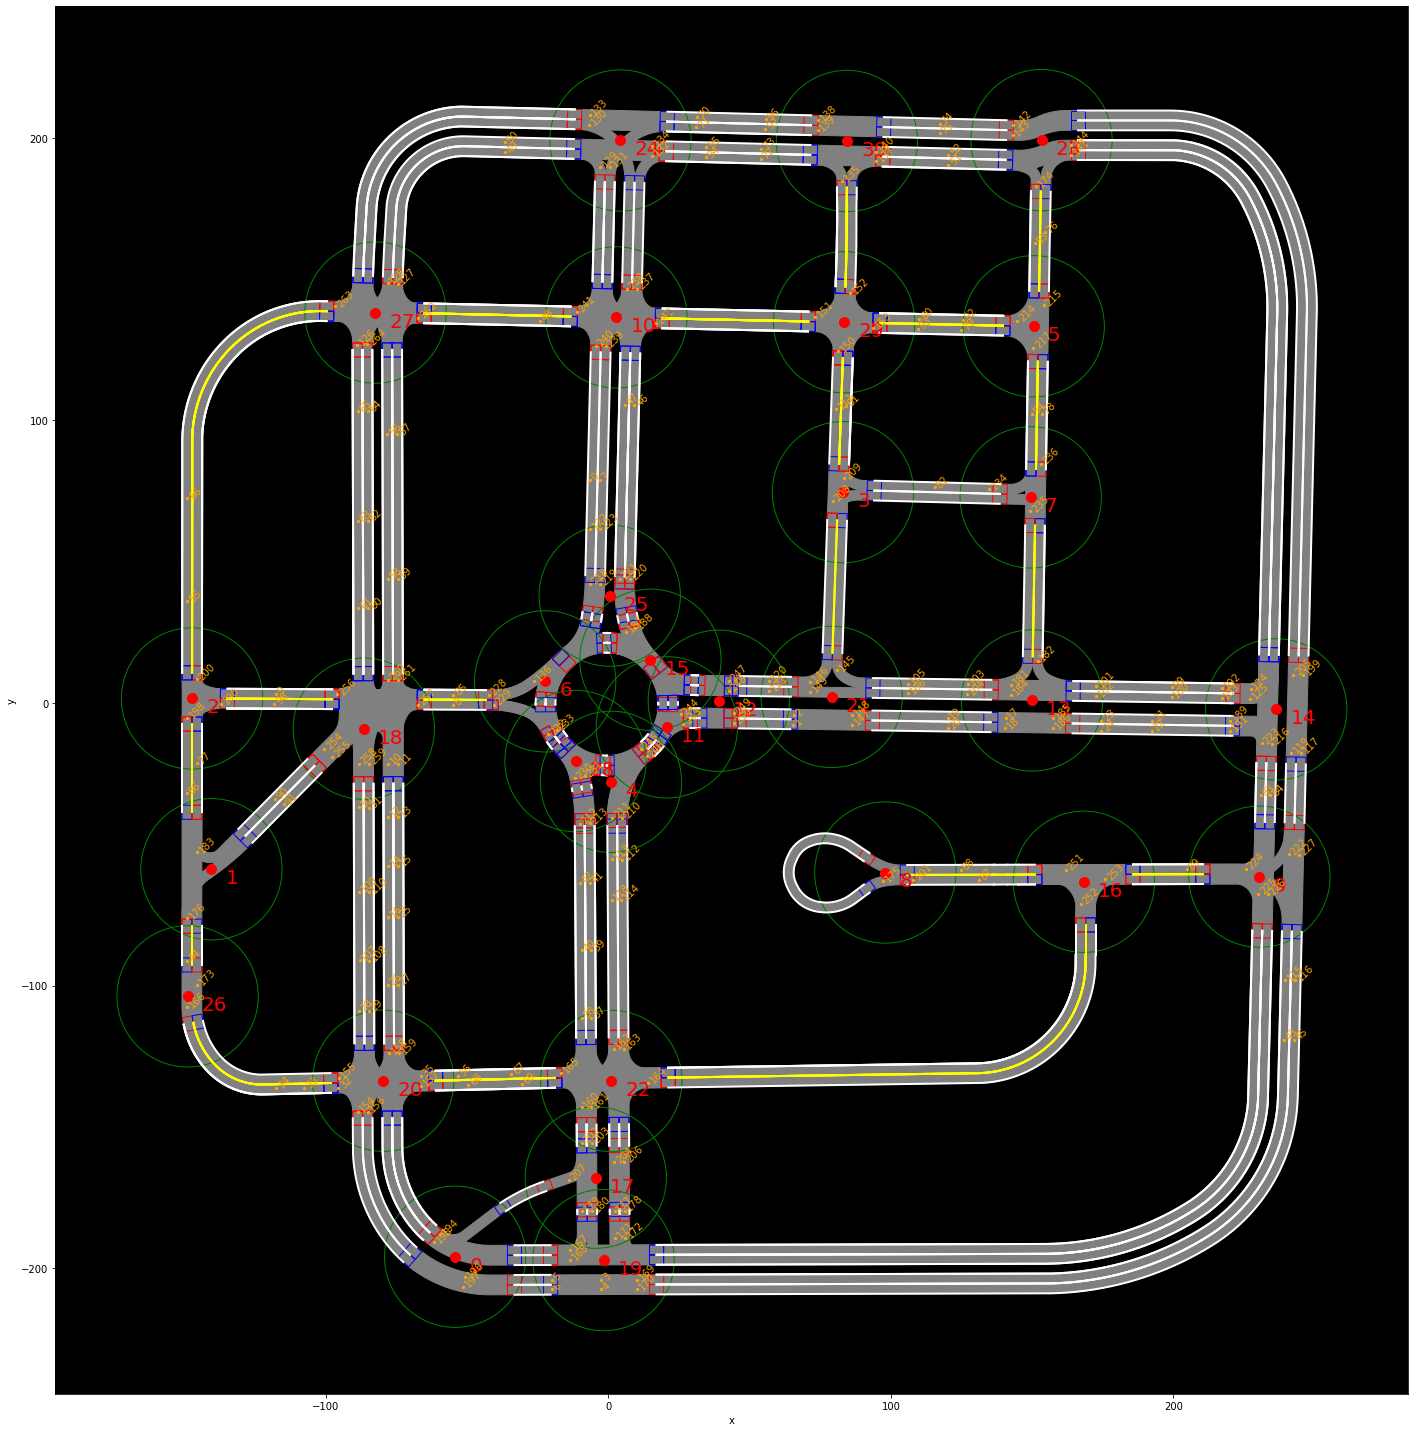

In [7]:
# Plot all the junctions and entrance/exits to/from the junctions
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax)

# Plot junction data
for idx, junction in enumerate(junctions):
    x, y = junction['pos']
    ax.plot(x, y, 'ro', markersize=10)
    ax.text(x + 5, y - 5, str(idx), color='r', size=20)
    circ = patches.Circle((x, y,), radius=25, color='g', fc='none')
    ax.add_patch(circ)
    for _wp1, _wp2 in junction['waypoints']:
        # entrances
        x, y, yaw, lane_width = _wp1
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
        ax.add_patch(bb)
        # exits
        x, y, yaw, lane_width = _wp2
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='r', fc='none')
        ax.add_patch(bb)

ax.scatter(spawn_points.T[0], spawn_points.T[1], s=5, c='orange', zorder=10)

for idx, point in enumerate(spawn_points):
    x, y = point[:2]
    ax.text(x, y, str(idx), size=10, c='orange', rotation=45)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

Selecting for specific points on the map. Needs CARLA server running.

In [5]:
client, world, carla_map = get_client_and_world_with('Town05')

In [25]:
selected_points = [
    spawn_points[265, :3], # spawn bottom of slope
]

x, y, z = selected_points[0][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
# middle of slope
selected_points.append(carlautil.to_location_ndarray(wp.next(60)[0], flip_y=True))

x, y, z = selected_points[0][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
# top of slope
selected_points.append(carlautil.to_location_ndarray(wp.next(120)[0], flip_y=True))

x, y, z = selected_points[0][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
# top of slope
selected_points.append(carlautil.to_location_ndarray(wp.next(360)[0], flip_y=True))

selected_points = np.stack(selected_points)
print(selected_points.shape)

(4, 3)


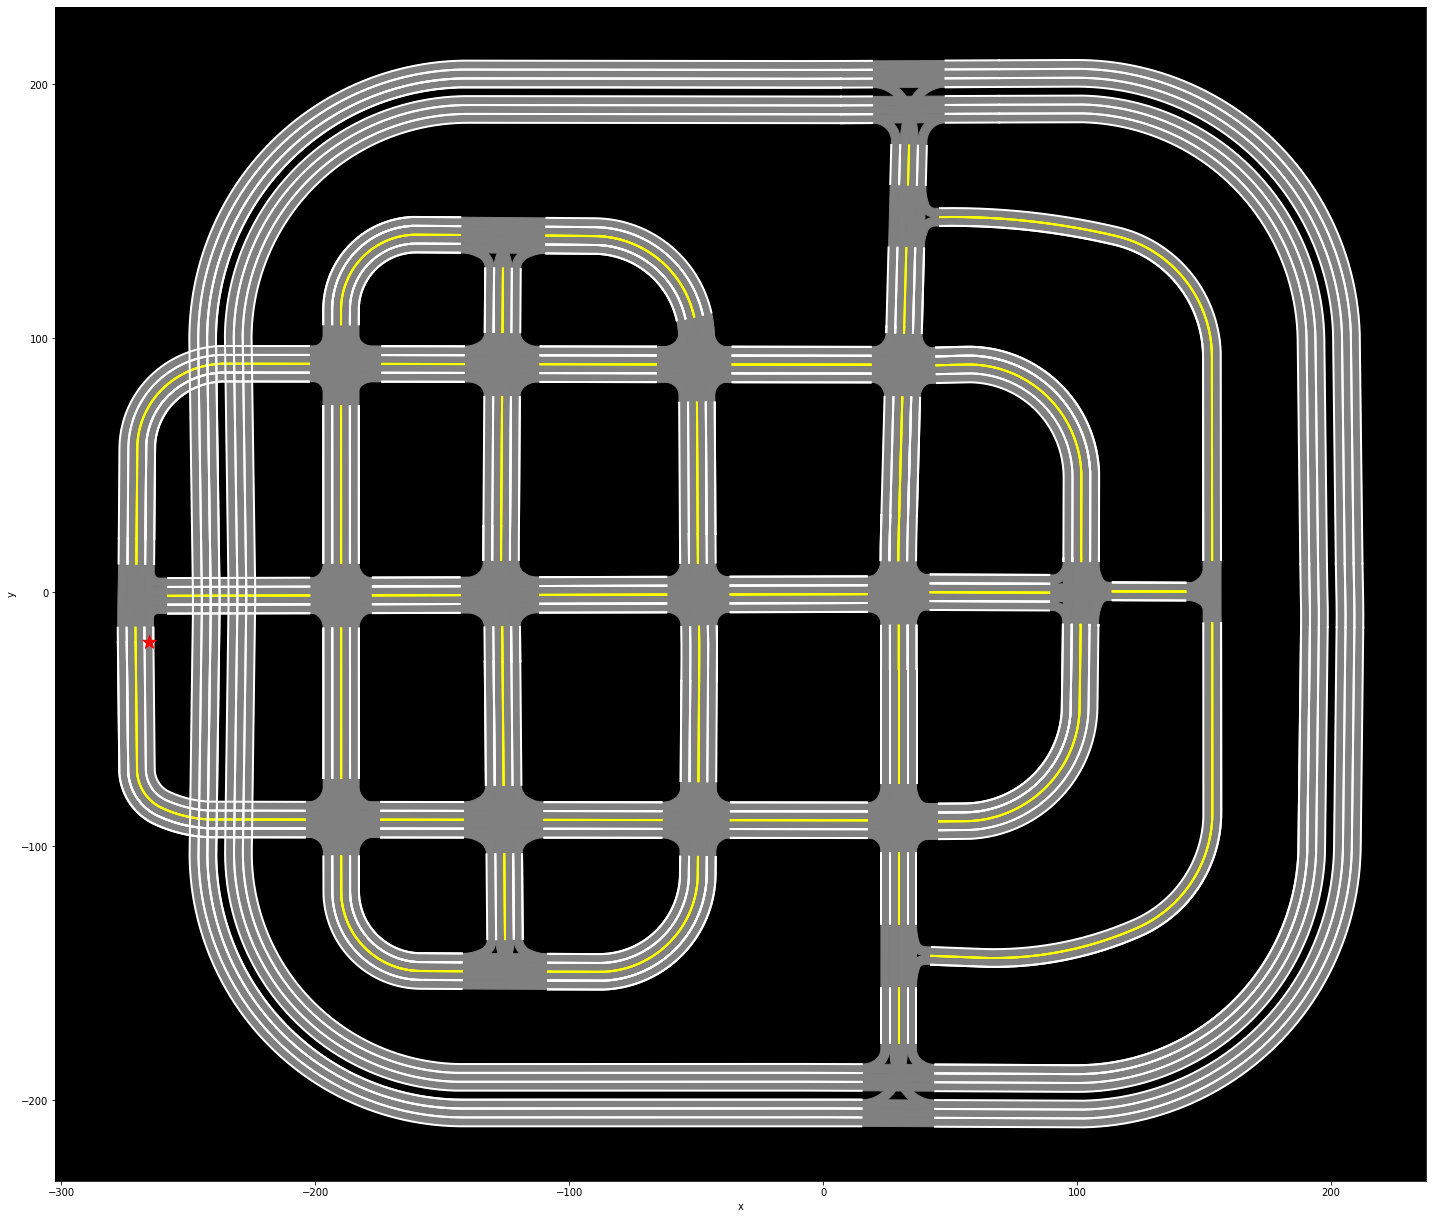

In [51]:
# there are 302 spawn points
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax)

# selected_points = spawn_points[245:250]#[None]
selected_points = spawn_points[244][None]
ax.scatter(selected_points.T[0], selected_points.T[1], marker='*', s=200, c='red', zorder=10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

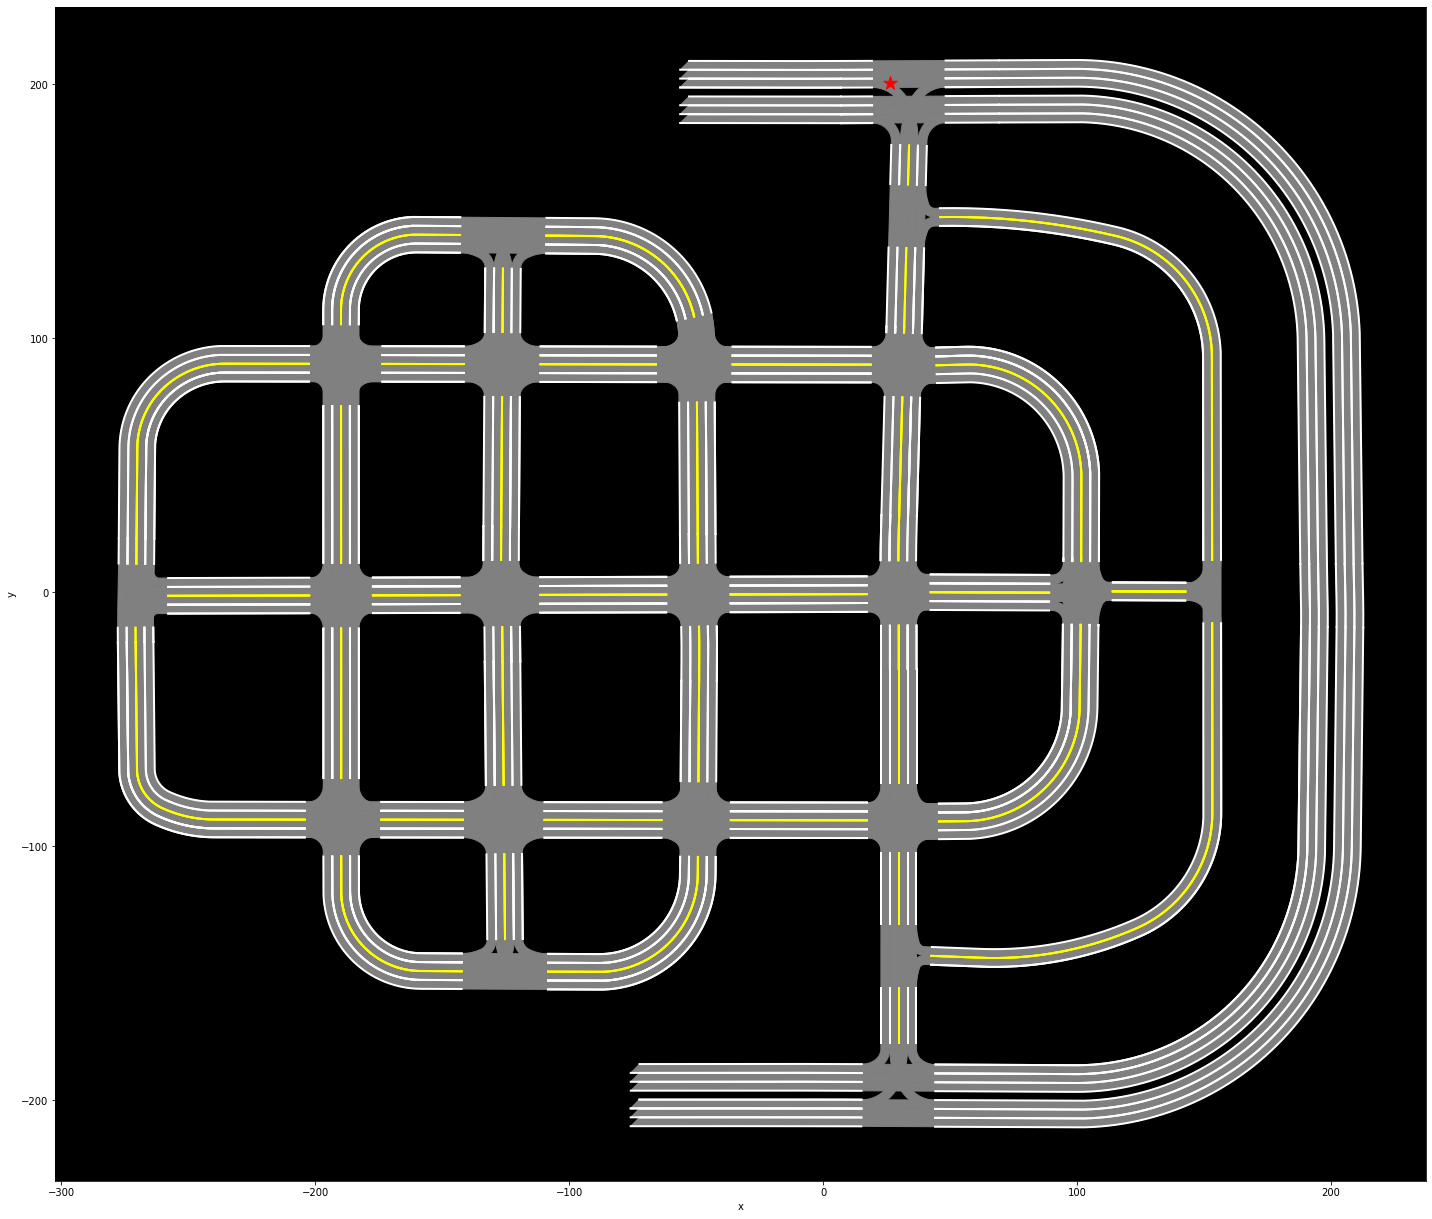

In [8]:
fig, ax = plt.subplots(figsize=(20,20))

_point = selected_points[0]
z = _point[2]
deriv = 6
zbound = np.array([z - deriv, z + deriv])

def split_line_by_mask(X, mask):
    # split X by inclusion or exclusion
    indices = np.where(np.diff(mask,prepend=np.nan))[0]
    l = np.split(X, indices)[1:]
    X_inclusion = l[::2] if mask[0] else l[1::2]
    X_exclusion = l[::2] if not mask[0] else l[1::2]
    return X_inclusion, X_exclusion

def remove_line_segments_by_condition(cond, lines):
    _lines = []
    for line in lines:
        splits, _ = split_line_by_mask(line, cond(line))
        _lines += splits
    return _lines

def split_polygon_by_mask(X, mask):
    # split X by inclusion or exclusion
    indices = np.where(np.diff(mask,prepend=np.nan))[0]
    l = np.split(X, indices)[1:]
    X_inclusion = l[::2] if mask[0] else l[1::2]
    X_exclusion = l[::2] if not mask[0] else l[1::2]
    if len(X_inclusion) % 2 == 0:
        # fold all
        n = len(X_inclusion)
        X_inclusion = util.map_to_list(np.concatenate, zip(X_inclusion[:n//2], X_inclusion[:n//2 - 1:-1]))
        # take middle and fold rest
        n = len(X_exclusion)
        X_exclusion = util.map_to_list(np.concatenate, zip(X_exclusion[:n // 2], X_exclusion[:n // 2:-1])) \
                + [X_exclusion[n // 2]]
    else:
        # take middle and fold rest
        n = len(X_inclusion)
        X_inclusion = util.map_to_list(np.concatenate, zip(X_inclusion[:n // 2], X_inclusion[:n // 2:-1])) \
                + [X_inclusion[n // 2]]
        # fold all
        n = len(X_exclusion)
        X_exclusion = util.map_to_list(np.concatenate, zip(X_exclusion[:n//2], X_exclusion[:n//2 - 1:-1]))
    return X_inclusion, X_exclusion

def remove_polygons_by_condition(cond, polygons):
    _polygons = []
    for polygon in polygons:
        splits, _ = split_polygon_by_mask(polygon, cond(polygon))
        _polygons += splits
    return _polygons

x, y = _point[:2]
ax.scatter(x, y, marker='*', s=200, c='red', zorder=10)

# _road_polygons = util.map_to_list(lambda a: a[(zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1])], road_polygons)
_road_polygons = remove_polygons_by_condition(
        lambda a: (zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1]), road_polygons)
for poly in _road_polygons:
    patch = patches.Polygon(poly[:, :2], fill=True, color='grey')
    ax.add_patch(patch)
# _yellow_lines = util.map_to_list(lambda a: a[(zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1])], yellow_lines)
_yellow_lines = remove_line_segments_by_condition(
        lambda a: (zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1]), yellow_lines)
for line in _yellow_lines:
    ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
# _white_lines = util.map_to_list(lambda a: a[(zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1])], white_lines)
_white_lines = remove_line_segments_by_condition(
        lambda a: (zbound[0] <= a[:,2]) & (a[:,2] <= zbound[1]), white_lines)
for line in _white_lines:
    ax.plot(line.T[0], line.T[1], c='white', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()